In [1]:
import numpy as np
from math import sqrt
from typing import Any

import pandas as pd
import seaborn as sb
import torch.jit
from lightning import Trainer
from lightning.lite import seed_everything
from sklearn import preprocessing

from custom_lib import Model, Data

In [2]:
%matplotlib inline
sb.set()

# Data Processing

In [3]:
data_set: Any = pd.read_csv('data/train_data.csv', encoding='utf-8')
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3070 entries, 0 to 3069
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Company         3070 non-null   object
 1   City            3050 non-null   object
 2   Country         3068 non-null   object
 3   Industry        3070 non-null   object
 4   Investor        2940 non-null   object
 5   Last Valuation  3070 non-null   int64 
 6   Unicorn         3070 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 168.0+ KB


In [4]:
data_set.head()

,Company,City,Country,Industry,Investor,Last Valuation,Unicorn
0,Slingshot Aerospace,Austin,United States,Aerospace,Techstars,200000000,0
1,Deepgram,San Francisco,United States,Artificial intelligence,NVIDIA,250000000,0
2,Sense,Cambridge,United States,Consumer Electronics,Schneider Electric,550000000,0
3,Zume,Camarillo,United States,Consumer,FJ Labs,2250000000,1
4,Plant Prefab,Rialto,United States,Architecture,ICT Capital,100000000,0


## Company Name

In [5]:
company: list = data_set['Company'].tolist()

In [6]:
def count_special_char(name: str) -> int:
	special_char: list = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@']
	special_char_count: int = 0
	for c in name:
		if c in special_char:
			special_char_count += 1

	return special_char_count

In [7]:
company_length: list = [len(c) for c in company]
company_special: list = [count_special_char(c) for c in company]

In [8]:
data_set.insert(0, 'Company Name Length', company_length)
data_set.insert(1, 'Company Name #Special Char', company_special)
data_set.drop('Company', axis=1, inplace=True)

In [9]:
data_set.head()

,Company Name Length,Company Name #Special Char,City,Country,Industry,Investor,Last Valuation,Unicorn
0,19,0,Austin,United States,Aerospace,Techstars,200000000,0
1,8,0,San Francisco,United States,Artificial intelligence,NVIDIA,250000000,0
2,5,0,Cambridge,United States,Consumer Electronics,Schneider Electric,550000000,0
3,4,0,Camarillo,United States,Consumer,FJ Labs,2250000000,1
4,12,0,Rialto,United States,Architecture,ICT Capital,100000000,0


## Country

In [10]:
data_set['Country'] = data_set['Country'].str.lower()
data_set['Country'].value_counts()

united states           2506
china                    173
india                     70
united kingdom            50
germany                   30
israel                    24
france                    24
canada                    19
south korea               17
brazil                    16
singapore                 14
sweden                     8
mexico                     8
australia                  8
indonesia                  7
hong kong                  7
netherlands                7
japan                      6
switzerland                6
ireland                    6
spain                      5
finland                    5
norway                     5
united arab emirates       4
belgium                    3
turkey                     3
thailand                   3
colombia                   3
philippines                2
chile                      2
italy                      2
south africa               2
lithuania                  2
croatia                    2
austria       

In [11]:
def country_mapping(country_name: str) -> int:
	country: dict = {'united states': 0, 'china': 1}
	if country_name in country.keys():
		return country[country_name]
	return len(country)

In [12]:
data_set['Country'] = data_set['Country'].map(country_mapping)

In [13]:
data_set['Country'].fillna(0, inplace=True)

In [14]:
data_set.head()

,Company Name Length,Company Name #Special Char,City,Country,Industry,Investor,Last Valuation,Unicorn
0,19,0,Austin,0,Aerospace,Techstars,200000000,0
1,8,0,San Francisco,0,Artificial intelligence,NVIDIA,250000000,0
2,5,0,Cambridge,0,Consumer Electronics,Schneider Electric,550000000,0
3,4,0,Camarillo,0,Consumer,FJ Labs,2250000000,1
4,12,0,Rialto,0,Architecture,ICT Capital,100000000,0


## City


In [15]:
data_set['City'] = data_set['City'].str.lower()
data_set['City'].value_counts()

san francisco            480
new york                 365
boston                    97
palo alto                 72
los angeles               66
                        ... 
north charleston           1
wayland                    1
lake oswego                1
honolulu                   1
la plaine saint-denis      1
Name: City, Length: 502, dtype: int64

In [16]:
def city_mapping(city_name: str) -> int:
	city: dict = {'san francisco': 0, 'new york': 1}
	if city_name in city.keys():
		return city[city_name]
	return len(city)

In [17]:
data_set['City'] = data_set['City'].map(city_mapping)

In [18]:
data_set['City'].fillna(data_set.groupby('Country')['City'].transform(lambda x: x.mode().iat[0]), inplace=True)

In [19]:
data_set.head()

,Company Name Length,Company Name #Special Char,City,Country,Industry,Investor,Last Valuation,Unicorn
0,19,0,2,0,Aerospace,Techstars,200000000,0
1,8,0,0,0,Artificial intelligence,NVIDIA,250000000,0
2,5,0,2,0,Consumer Electronics,Schneider Electric,550000000,0
3,4,0,2,0,Consumer,FJ Labs,2250000000,1
4,12,0,2,0,Architecture,ICT Capital,100000000,0


## Industry

In [20]:
data_set['Industry'] = data_set['Industry'].str.lower()
data_set['Industry'].value_counts()

artificial intelligence         239
fintech                         235
internet software & services    197
analytics                       151
biotechnology                   131
                               ... 
robotics                          1
product design                    1
film production                   1
dating                            1
consumer & retail                 1
Name: Industry, Length: 272, dtype: int64

In [21]:
def industry_mapping(industry_name: str) -> int:
	industry: dict = {'artificial intelligence': 0, 'fintech': 1, 'internet software & services': 2, 'analytics': 3, 'biotechnology': 4, 'health care': 5, 'e-commerce & direct-to-consumer': 6}
	if industry_name in industry.keys():
		return industry[industry_name]
	return len(industry)

In [22]:
data_set['Industry'] = data_set['Industry'].map(industry_mapping)

In [23]:
data_set.head()

,Company Name Length,Company Name #Special Char,City,Country,Industry,Investor,Last Valuation,Unicorn
0,19,0,2,0,7,Techstars,200000000,0
1,8,0,0,0,0,NVIDIA,250000000,0
2,5,0,2,0,7,Schneider Electric,550000000,0
3,4,0,2,0,7,FJ Labs,2250000000,1
4,12,0,2,0,7,ICT Capital,100000000,0


## Investor

In [24]:
data_set['Investor'] = data_set['Investor'].str.lower()
data_set['Investor'].value_counts()

andreessen horowitz       88
techstars                 77
alumni ventures           66
y combinator              63
sequoia capital           60
                          ..
davis capital partners     1
james parker               1
sacramento angels          1
jmcr partners              1
l capital partners         1
Name: Investor, Length: 1255, dtype: int64

In [25]:
def investor_mapping(investor_name: str) -> int:
	investor: dict = {'andreessen horowitz': 0, 'techstars': 1, 'alumni ventures': 2, 'y combinator': 3, 'sequoia capital': 4, '500 global': 5, 'insight partners': 6}
	if investor_name in investor.keys():
		return investor[investor_name]
	return len(investor)

In [26]:
data_set['Investor'] = data_set['Investor'].map(investor_mapping)

In [27]:
data_set['Investor'].fillna(0, inplace=True)

In [28]:
data_set.head()

,Company Name Length,Company Name #Special Char,City,Country,Industry,Investor,Last Valuation,Unicorn
0,19,0,2,0,7,1,200000000,0
1,8,0,0,0,0,7,250000000,0
2,5,0,2,0,7,7,550000000,0
3,4,0,2,0,7,7,2250000000,1
4,12,0,2,0,7,7,100000000,0


## Last Valuation

In [29]:
data_set['Last Valuation'].value_counts()

1000000000    281
15000000      152
10000000      146
150000000     141
200000000     135
             ... 
505000000       1
475000000       1
460000000       1
445000000       1
6700000000      1
Name: Last Valuation, Length: 388, dtype: int64

In [30]:
def valuation_mapping(valuation: int) -> int:
	half = sqrt(10)
	scientific: list = '{:e}'.format(valuation).split('e')
	tail: float = float(scientific[0])
	power: int = int(scientific[1])
	if tail >= half:
		power += 1

	return power

In [31]:
data_set['Last Valuation'] = data_set['Last Valuation'].map(valuation_mapping)

In [32]:
data_set.head()

,Company Name Length,Company Name #Special Char,City,Country,Industry,Investor,Last Valuation,Unicorn
0,19,0,2,0,7,1,8,0
1,8,0,0,0,0,7,8,0
2,5,0,2,0,7,7,9,0
3,4,0,2,0,7,7,9,1
4,12,0,2,0,7,7,8,0


# Correlation

In [33]:
# data_set.drop('Last Valuation', axis=1, inplace=True)
data_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_data = pd.DataFrame(data_scaler.fit_transform(data_set.drop('Unicorn', axis=1)), columns=data_set.drop('Unicorn', axis=1).columns, dtype=np.float16)
scaled_data['Unicorn'] = data_set['Unicorn'].astype(np.int16)

<AxesSubplot: >

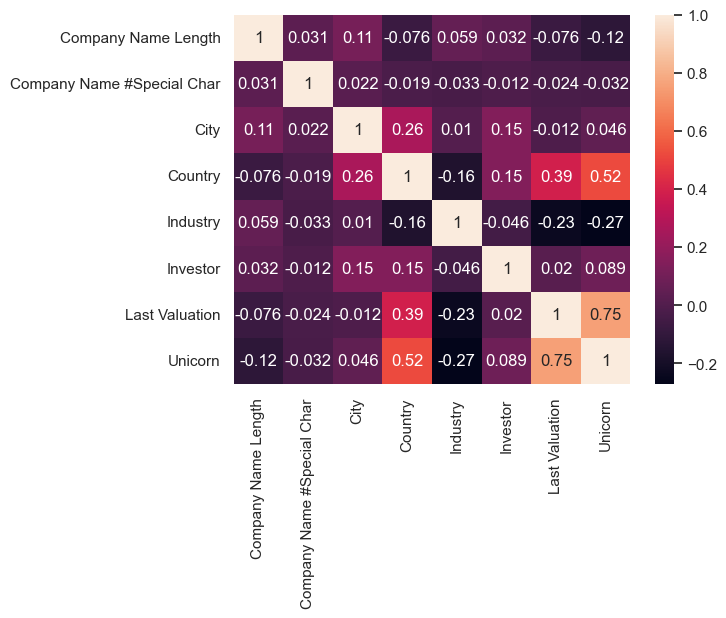

In [34]:
sb.heatmap(scaled_data.corr(), annot=True)

# Training

In [35]:
scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3070 entries, 0 to 3069
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Company Name Length         3070 non-null   float16
 1   Company Name #Special Char  3070 non-null   float16
 2   City                        3070 non-null   float16
 3   Country                     3070 non-null   float16
 4   Industry                    3070 non-null   float16
 5   Investor                    3070 non-null   float16
 6   Last Valuation              3070 non-null   float16
 7   Unicorn                     3070 non-null   int16  
dtypes: float16(7), int16(1)
memory usage: 48.1 KB


In [36]:
max_epoch: int = 75

In [37]:
seed_everything(2000, workers=True)
classifier = Model.Model()
data_loader = Data.DataModule(data=scaled_data)
trainer = Trainer(max_epochs=max_epoch, check_val_every_n_epoch=5)

Global seed set to 2000
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
print(classifier)

Model(
  (linear_1): Linear(in_features=7, out_features=5, bias=True)
  (linear_2): Linear(in_features=5, out_features=1, bias=True)
  (activation): Sigmoid()
  (loss_fn): BCELoss()
)


# Train

In [39]:
classifier.unfreeze()
trainer.fit(classifier, datamodule=data_loader)


  | Name       | Type    | Params
---------------------------------------
0 | linear_1   | Linear  | 40    
1 | linear_2   | Linear  | 6     
2 | activation | Sigmoid | 0     
3 | loss_fn    | BCELoss | 0     
---------------------------------------
46        Trainable params
0         Non-trainable params
46        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


# Test

In [40]:
classifier.freeze()
trainer.test(classifier, datamodule=data_loader, verbose=True)

Testing: 0it [00:00, ?it/s]

Test starts
Test Accuracy: 89.14%
Test ends


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.8914027214050293     │
└───────────────────────────┴───────────────────────────┘

[{'Accuracy': 0.8914027214050293}]

# Production

In [41]:
torch.jit.save(classifier.to_torchscript(), 'production.pt')